In [1]:
#library import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import lightgbm as lgb

In [2]:
#Taking a look at the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.dtypes #quick look at data types, potentially transform some variables into a categorical variable

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [4]:
train.shape #We have 891 rows and 12 columns, in other words, 891 passengers in the titanic before the tragedy.

(891, 12)

In [5]:
#checking for missing data
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

According to the data definitions, the 'cabin' variable is simply the cabin number. It has 687 missing data which means 77.1% of the cabin numbers are missing. If most the data were intact, it may have been possible to use the cabin numbers to predict survival based on the passenger location on the ship.

Age has approximately 19.9% missing data which is much more than a safe threshold for missing data. The missing data can be considered as missing at random (MAR) as it is entirely possible that the age is missing because the passenger did not survive. However, given that a passenger doesn't survive, their friends and family could provide the age of the victim when they search for them in the Titanic. This means that the missing data could also potentially be considered MNAR. further exploration is needed.

In [6]:
train[['Age', 'SibSp', 'Parch', 'Fare']].describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


In [7]:
#'Survived', 'Pclass', 'Sex' and 'Embarked' are all categorical variables
train[['Survived', 'Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']] = train[['Survived', 'Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']].astype('category')
test[['Survived', 'Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']] = train[['Survived', 'Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']].astype('category')
train.dtypes

PassengerId       int64
Survived       category
Pclass         category
Name             object
Sex            category
Age             float64
SibSp             int64
Parch             int64
Ticket         category
Fare            float64
Cabin          category
Embarked       category
dtype: object

### Numerical variables

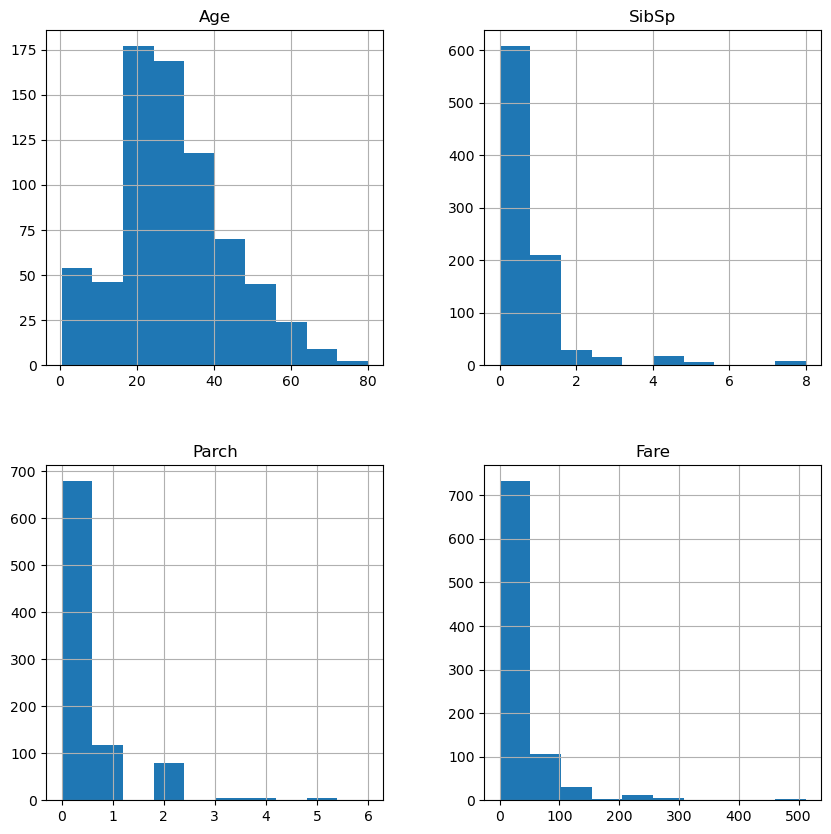

In [8]:
train[['Age', 'SibSp', 'Parch', 'Ticket', 'Fare']].hist(figsize=(10,10))
plt.show()

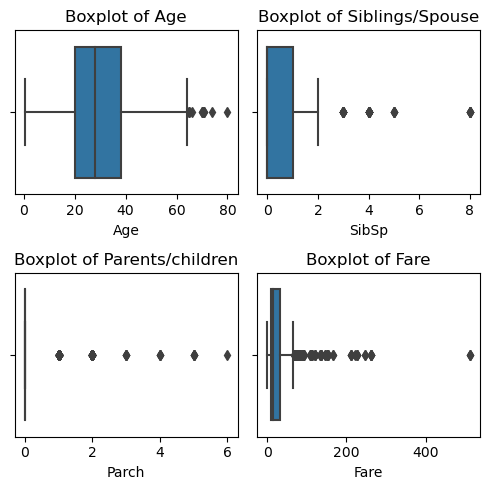

In [9]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(5, 5))

# Create boxplots on each subplot
sns.boxplot(x='Age', data=train, ax=axes[0, 0])
sns.boxplot(x='SibSp', data=train, ax=axes[0, 1])
sns.boxplot(x='Parch', data=train, orient='h', ax=axes[1, 0])
sns.boxplot(x='Fare', data=train, orient='h', ax=axes[1, 1])

# Set plot titles
axes[0, 0].set_title('Boxplot of Age')
axes[0, 1].set_title('Boxplot of Siblings/Spouse')
axes[1, 0].set_title('Boxplot of Parents/children')
axes[1, 1].set_title('Boxplot of Fare')

# Display the plot
plt.tight_layout()
plt.show()

Age - it seems that most people fall between 20 and 40 with the average age approaching 30. There is, however, a group of people of age 70 and above. Potentially, they are senior citizens looking to enjoy the cruise.

SibSp - most people also have a no or a single spouse with them on the cruise but there are a handful of people with 3 to 8 siblings on board as well.

Parch - same story as SibSp, most people on board do not have parents or children with them except for a small group who have 1 to 6 children.

Fare ($) - most passengers paid less than 50 for their tickets, however, there are passengers that have higher class tickets which are priced over 100 and one passenger with a ticket over 500. These are most likely the luxury class

### Counts for each catergorical variable

In [10]:
for column in ['Survived', 'Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']: 
    print(f"Value counts for {column}:")
    print(train[column].value_counts())
    print()

Value counts for Survived:
0    549
1    342
Name: Survived, dtype: int64

Value counts for Pclass:
3    491
1    216
2    184
Name: Pclass, dtype: int64

Value counts for Sex:
male      577
female    314
Name: Sex, dtype: int64

Value counts for Ticket:
1601        7
CA. 2343    7
347082      7
CA 2144     6
347088      6
           ..
345572      1
345364      1
343276      1
343275      1
347464      1
Name: Ticket, Length: 681, dtype: int64

Value counts for Cabin:
C23 C25 C27    4
G6             4
B96 B98        4
F2             3
C22 C26        3
              ..
C101           1
B94            1
B86            1
B82 B84        1
T              1
Name: Cabin, Length: 147, dtype: int64

Value counts for Embarked:
S    644
C    168
Q     77
Name: Embarked, dtype: int64



Survived - Of the total 891 passengers, only 342 survived which is about ~38.4%.

Pclass - over half the total passengers are in class 3 (lowest class), 24% is in class 1 (highest class) and 20.6% are in class 2 (middle class)

Sex - approximately 64.7% of the passengers are males while the rest are female.

Tickets - difficult to glean information from. Sometimes has alphabetic prefix followed by numeric data

Cabin - as mentioned before, 77% of data are missing but could potentially be used to discern passenger location based on cabin. Like tickets, has alphabetic prefix followed by numeric data. Could be Ship layer + cabin room.

Embarked - Embark location of cusotmers. Perhaps embarking from a different location could help with survival somehow(?)

## Exploring each variable

#### Perhaps passengers in a higher class in the ship have a better chance at survival? For this variable, each passenger is grouped in terms of then whether they survived.

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
dtype: int64


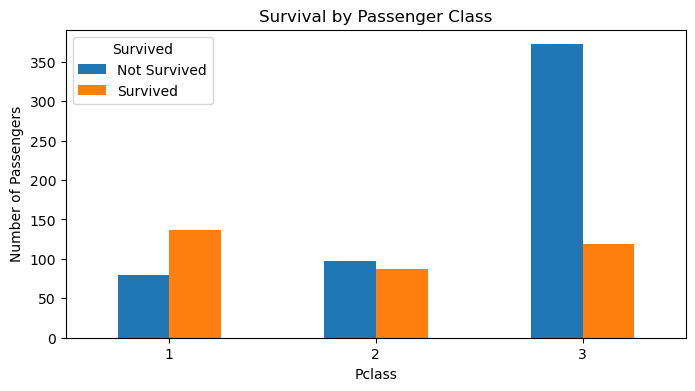

In [11]:
#Passenger class survivors
pclass_survive = train.groupby(['Pclass','Survived']).size()
print(pclass_survive)
pclass_survive_df = pclass_survive.reset_index(name='Count')
pclass_survive_pivot = pclass_survive_df.pivot_table(index='Pclass', columns='Survived', values='Count')

# Plot the bar chart
ax = pclass_survive_pivot.plot.bar(rot=0, figsize=(8, 4))
ax.set_xlabel("Pclass")
ax.set_ylabel("Number of Passengers")
ax.set_title("Survival by Passenger Class")
plt.xticks(range(len(pclass_survive_pivot.index)), pclass_survive_pivot.index)
plt.legend(["Not Survived", "Survived"], title="Survived")
plt.show()

#### Perhaps it is possible to glean passenger's social stratification based on title, maybe those of greater economic class have higher priority which improves survival?

In [12]:
#Name
# Extract title from 'Name' column
train['Title'] = train['Name'].str.extract(' ([a-zA-Z]+)\.')
test['Title'] = test['Name'].str.extract(' ([a-zA-Z]+)\.')
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

In [13]:
def title_type(x):
    if x == 'Mr':
        return 'Mr'
    elif x in ['Dr', 'Rev', 'Major', 'Col', 'Capt']:
        return 'Staff'
    elif x in ['Miss','Mrs','Ms']:
        return 'Miss'
    else:
        return 'Noble'
train['Title_type'] = train['Title'].apply(title_type)
test['Title_type'] = test['Title'].apply(title_type)

#### Between the two sexes, which has a higher porbability of surviving?

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
dtype: int64


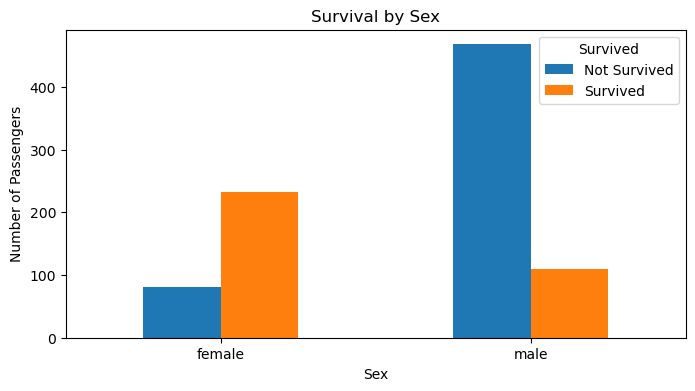

In [14]:
#Male v Female survivors
pclass_sex = train.groupby(['Sex','Survived']).size()
print(pclass_sex)
pclass_sex_df = pclass_sex.reset_index(name='Count')
pclass_sex_pivot = pclass_sex_df.pivot_table(index='Sex', columns='Survived', values='Count')

# Plot the bar chart
ax = pclass_sex_pivot.plot.bar(rot=0, figsize=(8, 4))
ax.set_xlabel("Sex")
ax.set_ylabel("Number of Passengers")
ax.set_title("Survival by Sex")
plt.xticks(range(len(pclass_sex_pivot.index)), pclass_sex_pivot.index)
plt.legend(["Not Survived", "Survived"], title="Survived")
plt.show()

Of the 342 survivors, 233 were female and 109 were male. Most of the ones that didn't survive were male which is about ~85.2%

#### What are the average ages of those who survived and those who didn't?

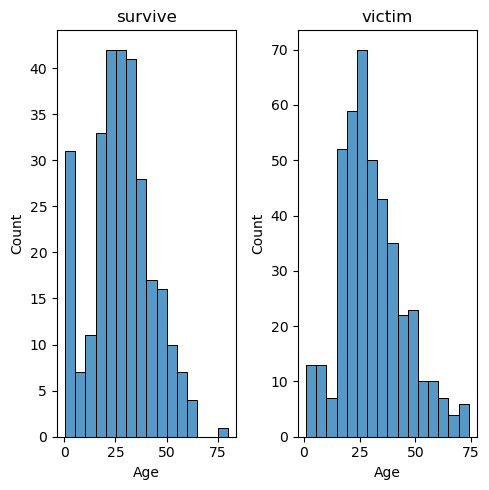

In [15]:
#Age
fig, axes = plt.subplots(1, 2, figsize=(5, 5))

# Create boxplots on each subplot
sns.histplot(x='Age', data=train[train['Survived']==1], ax=axes[0])
sns.histplot(x='Age', data=train[train['Survived']==0], ax=axes[1])

# Set plot titles
axes[0].set_title('survive')
axes[1].set_title('victim')

# Display the plot
plt.tight_layout()
plt.show()

Through visual inspection, it seems that the average age of those who survived is younger than those who didn't.

#### Do families or non-families have better survival rates?

In [16]:
train['SibPar'] = train['SibSp'] + train['Parch']
test['SibPar'] = test['SibSp'] + test['Parch']
train['SibPar'].unique() #shows possible family sizes

array([ 1,  0,  4,  2,  6,  5,  3,  7, 10], dtype=int64)

In [17]:
def fam_s(x):
    if x < 2:
        return 'not_family'
    elif x <= 3:
        return 'small'
    elif x <= 4:
        return 'medium'
    else:
        return 'large'
train['Family_size'] = train['SibPar'].apply(fam_s)

In [18]:
train['Family_size'].value_counts()

not_family    698
small         131
large          47
medium         15
Name: Family_size, dtype: int64

In [19]:
#confirming if categorizing family sizes is correct
train[['SibPar', 'Family_size']].sort_values(by = 'SibPar', ascending = False)
train[['SibSp', 'Parch','SibPar', 'Family_size']].loc[train['SibPar'] == 1]

,SibSp,Parch,SibPar,Family_size
0,1,0,1,not_family
1,1,0,1,not_family
3,1,0,1,not_family
9,1,0,1,not_family
18,1,0,1,not_family
...,...,...,...,...
861,1,0,1,not_family
866,1,0,1,not_family
874,1,0,1,not_family
879,0,1,1,not_family


Survived  Family_size
0         large           40
          medium          12
          not_family     446
          small           51
1         large            7
          medium           3
          not_family     252
          small           80
dtype: int64


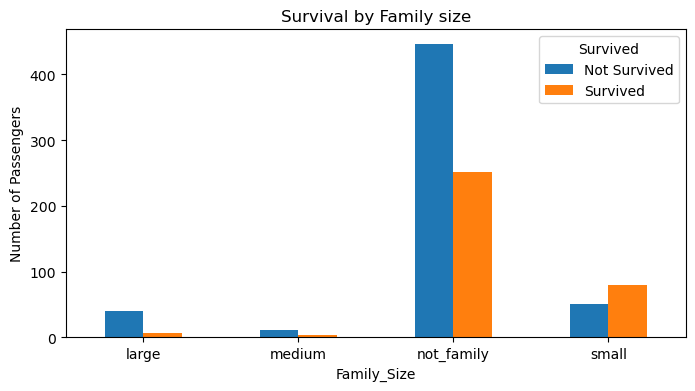

In [20]:
survive_fam = train.groupby(['Survived','Family_size']).size()
print(survive_fam)

survive_fam_df = survive_fam.reset_index(name='Count')
survive_fam_pivot = survive_fam_df.pivot_table(index='Family_size', columns='Survived', values='Count')

# Plot the bar chart
ax = survive_fam_pivot.plot.bar(rot=0, figsize=(8, 4))
ax.set_xlabel("Family_Size")
ax.set_ylabel("Number of Passengers")
ax.set_title("Survival by Family size")
plt.xticks(range(len(survive_fam_pivot.index)), survive_fam_pivot.index)
plt.legend(["Not Survived", "Survived"], title="Survived")
plt.show()

In [21]:
#ticket prefix
def extract_prefix(s):
    match = re.match(r'^[^ ]+', s)
    if match:
        # If the matched string starts with a digit, return NaN
        if match.group(0)[0].isdigit():
            return 'none'
        else:
            return match.group(0)
    else:
        return 'none'
train['Ticket_Prefix'] = train['Ticket'].apply(extract_prefix)

In [22]:
train['Ticket_Prefix'].value_counts()

none          661
PC             60
C.A.           27
STON/O         12
A/5            10
W./C.           9
CA.             8
SOTON/O.Q.      8
A/5.            7
SOTON/OQ        7
STON/O2.        6
CA              6
F.C.C.          5
C               5
SC/PARIS        5
S.O.C.          5
SC/Paris        4
LINE            4
A/4             3
PP              3
A/4.            3
S.O./P.P.       3
SC/AH           3
A.5.            2
A./5.           2
P/PP            2
WE/P            2
SOTON/O2        2
S.C./PARIS      2
S.W./PP         1
F.C.            1
A/S             1
SO/C            1
W/C             1
SC              1
SCO/W           1
SW/PP           1
Fa              1
S.O.P.          1
S.C./A.4.       1
A4.             1
S.P.            1
W.E.P.          1
C.A./SOTON      1
Name: Ticket_Prefix, dtype: int64

In [23]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Title_type,SibPar,Family_size,Ticket_Prefix
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Mr,1,not_family,A/5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Miss,1,not_family,PC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Miss,0,not_family,STON/O2.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Miss,1,not_family,none
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Mr,0,not_family,none


#### How does ticket fare and survival relate?

In [24]:
#Observe corelation of survival and fare price
train['Survived'].corr(train['Fare'])

0.25730652238496227

There is a minor positive correlation between ticket fare and whether a passenger survives

In [25]:
survive_fare = train.groupby('Survived')['Fare'].mean()
print(survive_fare)

Survived
0    22.117887
1    48.395408
Name: Fare, dtype: float64


The average ticket fare for those who survived is higher than those who didn't survive. Possible over representation of non-survivors as there are more who didn't survive thaan those who did.

In [26]:
#cabin type
train['Cabin'] = train['Cabin'].cat.add_categories('Unknown')
train['Cabin'] = train['Cabin'].fillna('Unknown')

def cabin_t(x):
    if x == "Unknown":
        return 'U'
    else:
        return x[0]

train['Cabin_type'] = train['Cabin'].apply(cabin_t)

In [27]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Title_type,SibPar,Family_size,Ticket_Prefix,Cabin_type
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S,Mr,Mr,1,not_family,A/5,U
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Miss,1,not_family,PC,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,Miss,Miss,0,not_family,STON/O2.,U
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Miss,1,not_family,none,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknown,S,Mr,Mr,0,not_family,none,U
